In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import h5py
import scipy.stats

import matplotlib
matplotlib.rcParams.update({'font.size': 8,'figure.dpi':150})
mm = 1/25.4

In [2]:
jpl_gridded_grace = xr.load_dataset('~/Large_Datasets/GRCTellus.JPL.200204_202302.GLO.RL06.1M.MSCNv03.nc')
                                         #             GRCTellus.JPL.200204_202312.GLO.RL06.1M.MSCNv03CRI.nc
jpl_mascon_data = xr.load_dataset('JPL_MSCNv02_PLACEMENT.nc')

In [3]:
def remove_climatology(x,t=None):
    '''Exactly what it says on the box. Remove the mean seasonal cycle
    Code adapted from CAFE-60_from_courtney.ipynb'''
    x1 = x.sel(time=slice('2003-01','2010-01'))
    if not t is None:
        x1 = x1.assign_coords({'time':t.isel(time=slice(0,120))})
    clim = x1.groupby('time.month').mean('time')
    anom = (x.groupby('time.month') - clim).drop('month')
    return anom

In [4]:
def build_window(t0, length):
    t0 = str(np.array(t0).astype('datetime64[M]')) #Shouldn't be this hard but apparently is
    y0 = int(t0[:4])
    m0 = int(t0[5:])
    
    assert m0>0, 'Month must be between 1 and 12 inclusive'
    out = []
    for i in range(length):
        y = y0+(m0+i-1)//12
        m = (m0 +i-1)%12+1
        out.append(str(y)+"-{:02d}".format(m))
    return out

In [5]:
def low_pass(x,w, verbose = False):
    ''' roll a gaussian over everything
    x is data you're applying it to
    w is window length in months
    Assume we have a time dimension in np.datetime64'''
    out = []
    all_time = build_window(x.time[0],int((x.time[-1]-x.time[0])/(np.timedelta64(24,'h')*365/12)))
    for t in all_time[:-w]:
        window = build_window(t, w)
        weights = xr.DataArray(np.exp(-np.linspace(-3,3,w)**2/2),dims=('time'),coords = {'time':window})
        
        total_weights = 0
        weighted_sum = 0
        for t2 in window:
            try:
                xdata = float(x.sel(time=t2))
                wdata = float(weights.sel(time=t2))
                weighted_sum += wdata*xdata
            except TypeError as err:
                if verbose:
                    print(err) #I'm pretty sure this error is just when stuff doesn't exist
                    print(t2)
                xdata = np.nan
                wdata = 0
            total_weights+=wdata
            
        if total_weights < np.sum(weights)*0.75: #If more than a quarter of the data is missing
            weighted_ave = np.nan
        else:
            weighted_ave = weighted_sum/total_weights
        
        out.append(weighted_ave)

    return xr.DataArray(out,dims=['time',],coords = [np.array(all_time[w//2:-w//2],np.datetime64)])

In [6]:
jpl_grace_np = np.zeros((jpl_mascon_data.mascon_id.shape[0],jpl_gridded_grace.time.shape[0]))

for i, mc_id in enumerate(jpl_mascon_data.mascon_id):
    jpl_grace_np[i] = jpl_gridded_grace.sel(
                                    lat = jpl_mascon_data.mascon_lat[i],
                                    lon = jpl_mascon_data.mascon_lon[i],
                                    method='nearest').lwe_thickness

jpl_grace_np = jpl_grace_np*1000*9.801/100/10**4 #Into dbar

jpl_grace_time = np.array(jpl_gridded_grace.time)
print(jpl_grace_time[144])
jpl_grace_time[144] = '2015-05-01'

jpl_grace = xr.DataArray(jpl_grace_np,
                         dims=('mc','time'),
                         coords=(jpl_mascon_data.mascon_id,jpl_grace_time))

2015-04-27T00:00:00.000000000


In [7]:
#taken from the worst RMSE in any model in hr_paper_everything0.ipynb on gadi:/~/x77/jj8842/results/
#GFDL pacific is using the ACCESS0.1 density threshold rather than the calculated one, for reasons explained in the SI
worst_RMSE = {('jpl','Pacific'):0.517, #GFDL at 1037.08
              ('jpl','Atlantic'):0.412, #ACCESS-OM2-01
              ('jpl','Indian'):0.446, #GFDL
             }

In [11]:
ts_pile = {}
uf_ts_pile = {}
for i, id in enumerate(('Pacific','Atlantic','Indian','RAPID')):
    weights = xr.load_dataset('230510_'+id+'.nc').weights
    timeseries = low_pass((remove_climatology(weights*jpl_grace).sum('mc'))/1037/10**6,24)
    ts_pile[('jpl',id)] = timeseries
    
    uf_timeseries = remove_climatology(weights*jpl_grace).sum('mc')/1037/10**6
    uf_ts_pile[('jpl',id)] = uf_timeseries    
    
ts_pile['jpl','Total'] = ts_pile['jpl','Pacific']+ts_pile['jpl','Atlantic']+ts_pile['jpl','Indian']
uf_ts_pile['jpl','Total'] = uf_ts_pile['jpl','Pacific']+uf_ts_pile['jpl','Atlantic']+uf_ts_pile['jpl','Indian']

/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_48809/1627629691.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  anom = (x.groupby('time.month') - clim).drop('month')
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_48809/1550061418.py:34: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return xr.DataArray(out,dims=['time',],coords = [np.array(all_time[w//2:-w//2],np.datetime64)])
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_48809/1627629691.py:8: DeprecationWarning: dropping variables using `drop` is deprecat

## Figure 8

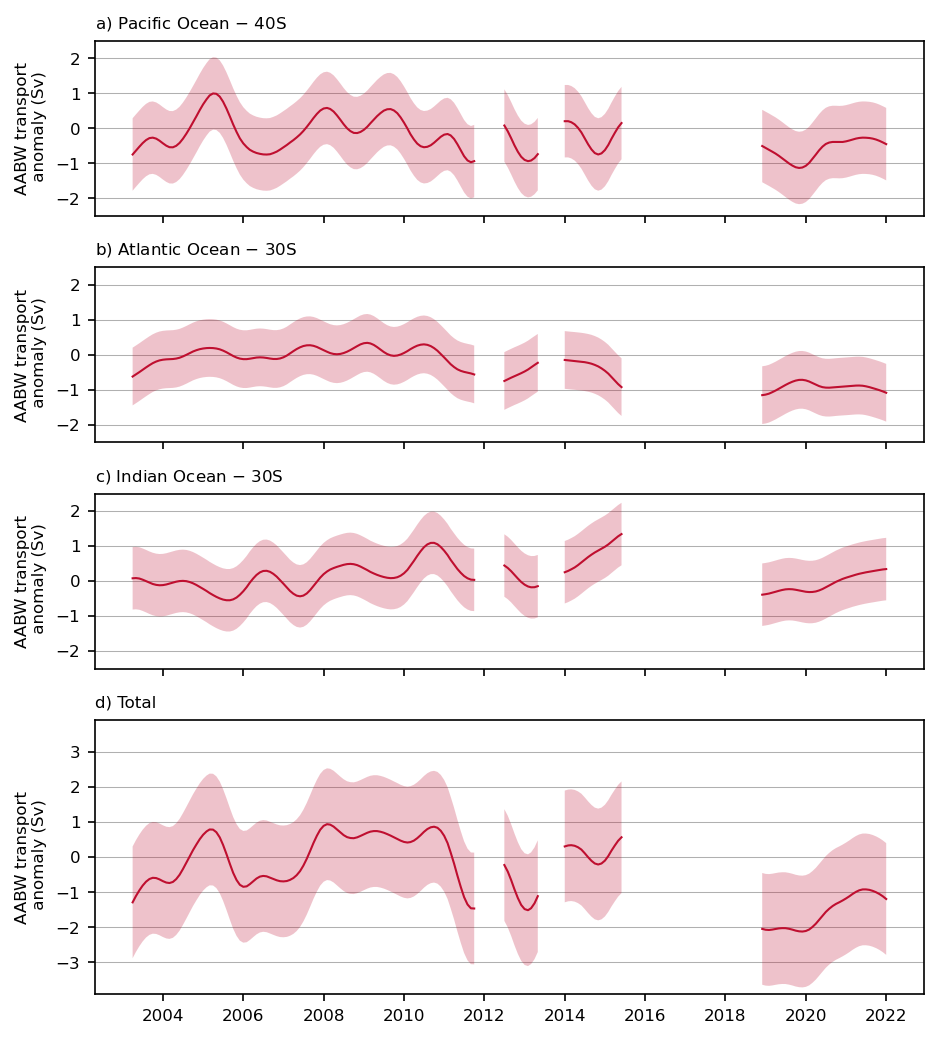

In [10]:
fig, ax = plt.subplots(4,1,figsize=(160*mm,177*mm),sharex=True,height_ratios=[3,3,3,4.7])

colors = ('#BF0F30','#5276A9')
titles = ('a) Pacific Ocean $-$ 40S','b) Atlantic Ocean $-$ 30S','c) Indian Ocean $-$ 30S','d) Total')
linestyles = ('-','dashed')
worst_RMSE['jpl','Total'] = np.sqrt(worst_RMSE['jpl','Pacific']**2+worst_RMSE['jpl','Atlantic']**2+worst_RMSE['jpl','Indian']**2)

for i, id in enumerate(('Pacific','Atlantic','Indian','Total')):
    p1 = []
    for j,loc in enumerate(('jpl',)):
        p1.append(ax[i].plot(ts_pile[loc,id].time,ts_pile[loc,id],c=colors[j],linewidth=1,zorder=9,linestyle=linestyles[j])[0])
        s2 = worst_RMSE[loc,id]*2
        ax[i].fill_between(ts_pile[loc,id].time, ts_pile[loc,id]-s2,ts_pile[loc,id]+s2,
                           zorder=10,alpha=0.25,facecolor=colors[j],edgecolor='None',label=loc.upper())
        p1.append(ax[i].fill(np.NaN, np.NaN, colors[j], alpha=0.25)[0])
        ax[i].set_ylabel('AABW transport\n anomaly (Sv)')
        ax[i].set_title(titles[i],fontsize=titlefontsize,loc='left')
        ax[i].set_ylim(-2.5,2.5)
        ax[i].grid(visible=True,axis='y',linewidth=0.5)

ax[3].set_ylim(-2.5*4.7/3,2.5*4.7/3)

    
plt.tight_layout()
plt.savefig('thesis_images/hr_AABW_estimate_240505.pdf')